In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.autograd import Variable

from utils import *
from data_loader import get_train_loader

%matplotlib inline

# dir params
root_dir = './data/train/'

In [2]:
# ensuring reproducibility
torch.manual_seed(423212)

## View Data

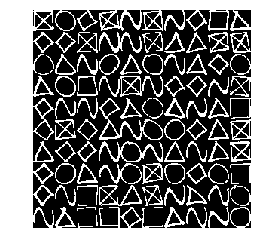

In [3]:
features = pickle.load(open('./data/dump/X_train.p', "rb"))

# randomly select 100
mask = np.random.choice(features.shape[0], 100, replace=False)  
sample = features[mask]
view_images(sample, save=True, name='dataset.png')

## Custom DataLoader

In [4]:
# transforms
train_transform = transforms.Compose([
    transforms.Scale((28, 28)),
    transforms.ToTensor(),
])

kwargs = {'shuffle': True, 'num_workers': 4}
train_loader = get_train_loader(root_dir, train_transform, **kwargs)

## Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 6)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [6]:
def accuracy(predicted, ground_truth):
    """
    Utility function for calculating the accuracy of the model.
    Params
    ------
    - predicted: (torch.FloatTensor)
    - ground_truth: (torch.LongTensor)
    Returns
    -------
    - acc: (float) % accuracy.
    """
    predicted = torch.max(predicted, 1)[1]
    total = len(ground_truth)
    correct = (predicted == ground_truth).sum().double()
    acc = 100 * (correct / total)
    return acc.data[0]

In [7]:
model = ConvNet()
optimizer = optim.Adam(model.parameters())

print('Number of model parameters: {:,}'.format(sum([p.data.nelement() for p in model.parameters()])))

Number of model parameters: 21,636


In [8]:
def train(epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        acc = accuracy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0], acc))

In [9]:
num_epochs = 30

for epoch in range(1,  num_epochs + 1):
    train(epoch)

Train Epoch: 1 [0/311 (0%)]	Loss: 1.775169	Acc: 27.343750
Train Epoch: 1 [128/311 (33%)]	Loss: 1.766149	Acc: 27.343750
Train Epoch: 1 [110/311 (67%)]	Loss: 1.751619	Acc: 16.363636
Train Epoch: 2 [0/311 (0%)]	Loss: 1.737194	Acc: 21.093750
Train Epoch: 2 [128/311 (33%)]	Loss: 1.687010	Acc: 27.343750
Train Epoch: 2 [110/311 (67%)]	Loss: 1.660310	Acc: 30.909091
Train Epoch: 3 [0/311 (0%)]	Loss: 1.639619	Acc: 25.781250
Train Epoch: 3 [128/311 (33%)]	Loss: 1.602904	Acc: 28.125000
Train Epoch: 3 [110/311 (67%)]	Loss: 1.617259	Acc: 18.181818
Train Epoch: 4 [0/311 (0%)]	Loss: 1.519526	Acc: 32.031250
Train Epoch: 4 [128/311 (33%)]	Loss: 1.505675	Acc: 33.593750
Train Epoch: 4 [110/311 (67%)]	Loss: 1.516455	Acc: 38.181818
Train Epoch: 5 [0/311 (0%)]	Loss: 1.417729	Acc: 54.687500
Train Epoch: 5 [128/311 (33%)]	Loss: 1.392105	Acc: 57.031250
Train Epoch: 5 [110/311 (67%)]	Loss: 1.280072	Acc: 67.272727
Train Epoch: 6 [0/311 (0%)]	Loss: 1.276326	Acc: 60.156250
Train Epoch: 6 [128/311 (33%)]	Loss: 1.213

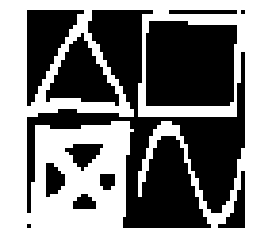

In [11]:
X_test = pickle.load(open("./data/test/X_test.p", "rb"))
poop = np.transpose(X_test, [0, 2, 3, 1])
view_images(poop, save=True, name='extracted.png')

gd_Truth = [5, 3, 1, 4]
labels = np.array(gd_Truth)
labels = np.resize(labels, [labels.shape[0], 1])

X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(labels)

In [27]:
def test():
    correct = 0
    data, target = Variable(X_test, volatile=True), Variable(y_test)
    output = model(data)
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    print('Accuracy: {}/{} ({:.0f}%)\n'.format(correct, X_test.size()[0],
        100. * correct / X_test.size()[0]))

In [28]:
test()

Accuracy: 4/4 (100%)



In [25]:
correct_names = [num2name(x) for x in gd_Truth]
prediction = list(pred.numpy().flatten())
prediction = [num2name(x) for x in prediction]
print("Gd Truth: {}".format(correct_names))
print("Predictions: {}".format(prediction))

Gd Truth: ['triangle', 'square', 'cross', 'squiggly']
Predictions: ['triangle', 'square', 'cross', 'squiggly']
